## Задача: спрогнозировать "временной" ряд для категориальных переменных.
### Иногда такая задача имеет место на практике, когда например необходимо спрогнозировать не сами продажи, а какой-то агрегат от них, например категории, к которым относятся проданные товары. 

###### К примеру могут быть такие категории:
###### $\bullet$ 0 - Не продано ни одного товара за день
###### $\bullet$ 1 - Продано мало товаров за день
###### $\bullet$ 2 - Продано среднее количество товаров за день
###### $\bullet$ 3 - Продано выше среднего товаров за день
###### $\bullet$ 4 - Продано большое количество товаров за день
###### Под средним здесь может пониматься среднее количество товаров, проданных за все время.

Импортируем необходимые библиотеки

In [ ]:
import pandas as pd 
import numpy as np 
import itertools
import math
import time
import sys
#from matplotlib import pyplot as plt

from scipy import stats
from numpy import linalg as LA
from collections import Counter

%pylab inline

Читаем данные

In [7]:
data = pd.read_csv('digits.txt')
data_all = data # make a data copy
data.columns = ["element"]
data.head()

,element
0,2
1,4
2,2
3,2
4,4


In [39]:
data.element.values[-5:]

array([2, 3, 2, 1, 1], dtype=int64)

In [40]:
data.element.values.mean()

2.0490490490490489

In [41]:
data.describe()

,element
count,999.000000
mean,2.049049
std,1.091320
min,0.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,6.000000


Всего в датасете 7 категорий

In [42]:
set(data.element)

{0, 1, 2, 3, 4, 5, 6}

In [43]:
data.element.value_counts()

2    346
1    283
3    230
4     72
0     50
5     14
6      4
Name: element, dtype: int64

Временной ряд (в терминах категорий) выглядит следующим образом:

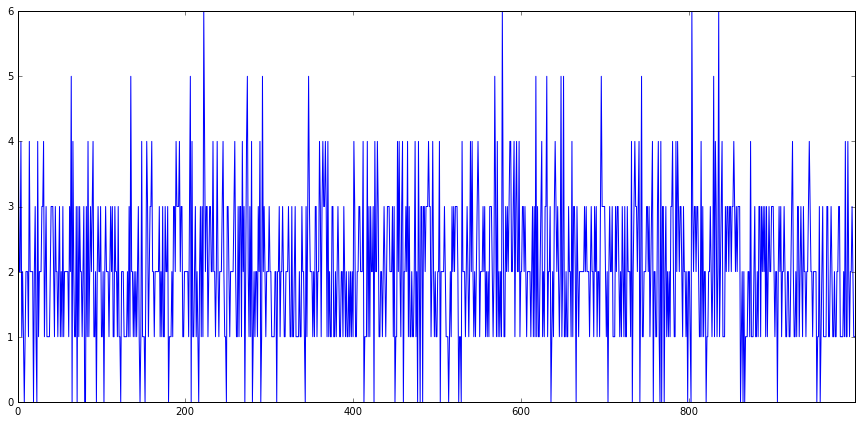

In [44]:
plt.figure(figsize(15,7))
data.element.plot()
pylab.show()

# 1. Markov Chains

Напишем некоторые вспомогательные функции

In [52]:
# Последовательности чисел длины order
def GetShiftingWindows(input_data, order):
    out_data = [list(input_data)[x:x+order] for x in range(len(list(input_data)) - order + 1)]
    return out_data

def unique_data(data):
    unique_data = [list(x) for x in set(tuple(x) for x in data)]
    return unique_data

def get_list_of_lists(list_of_tuples):
    list_of_lists = []                                                          
    for tuple in list_of_tuples:
        list_of_lists.append(list(tuple))

    return list_of_lists

def progressbar(progress):
    barLength = 100 # Modify this to change the length of the progress bar
    status = ""
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
        status = "error: progress var must be float\r\n"
    if progress < 0:
        progress = 0
        status = "Halt...\r\n"
    if progress >= 1:
        progress = 1
        status = "Done...\r\n"
    block = int(round(barLength*progress))
    text = "\rPercent: [{0}] {1}% {2}".format( "#"*block + "-"*(barLength-block), round(progress*100,3), status)
    sys.stdout.write(text)
    sys.stdout.flush()

Определим начальное вероятностное распределение $\pi$ по имеющимся данным

In [46]:
def pi_initial_(data, order):
    
    moving_window_sequence = GetShiftingWindows(data.element, order)
    
    N = len(moving_window_sequence)
    
    pi = np.zeros(shape=(np.power(len(set(data.element)),order)))
       
    multituples = [tuple(l) for l in moving_window_sequence]
    tc = dict(Counter(multituples))
    
    denominators = np.array(tc.values())

    st = [p for p in itertools.product(set(data.element), repeat=order)]
    st = get_list_of_lists(st)
    exceptions = [a for a in st if a not in moving_window_sequence]
    
    for el_num in range(pi.shape[0]):
        if st[el_num] not in exceptions:
            pi[el_num] = round(float(tc.get(tuple(st[el_num]))/N),6)
        else:
            pi[el_num] = 0.0
    
    pi = pi.T   
    
    return pi

In [47]:
def pi_initial(lst, order):
    
    t0 = time.time()
    
    moving_window_sequence = GetShiftingWindows(lst, order)
    
    N = len(moving_window_sequence)
    
    pi = np.zeros(shape=(np.power(len(set(lst)),order)))
       
    multituples = [tuple(l) for l in moving_window_sequence]
    tc = dict(Counter(multituples))
    
    denominators = np.array(tc.values())

    st = [p for p in itertools.product(set(lst), repeat=order)]
    st = get_list_of_lists(st)
    exceptions = [a for a in st if a not in moving_window_sequence]

    print('Initial probability distribution')
    
    for el_num in range(pi.shape[0]):
        #progressbar(float(el_num)/(pi.shape[0]-1))
        if st[el_num] not in exceptions:
            pi[el_num] = round(float(tc.get(tuple(st[el_num]))/N),6)
        else:
            pi[el_num] = 0.0
    
    pi = pi.T
    
    t1 = time.time()
    print('Elapsed time:',round(t1-t0,2),' sec')
    print('-'*30)
    
    return pi

In [48]:
matrix = pi_initial(data.element,1)
matrix

Initial probability distribution
Elapsed time: 0.18  sec
------------------------------


array([ 0.05005 ,  0.283283,  0.346346,  0.23023 ,  0.072072,  0.014014,
        0.004004])

| Order = 1 |   s = 0   |   s = 1   |   s = 2   |   s = 3   |   s = 4   |   s = 5   |   s = 6   |
| --------- |:-----:| -----:| -----:| -----:| -----:| -----:| -----:|
| p         |0.05005|0.283283| 0.346346    | 0.2302    |  0.072072    | 0.014014    | 0.004004    |


In [49]:
def polynom(lst,order):
    ans = 0
    len_set = len(set(data.element))

    for i in range(order,0,-1):
        ans +=lst[order-i]*len_set**(i-1)

    return ans

Напишем функцию заполняющую матрицу переходных вероятностей

In [50]:
def fill_transitionMatrix(lst, order):
    
    #t0 = time.time()
    #print('\nTransition probabilities matrix')
    
    temp_list = []
    
    # Создадим матрицу переходов
    transitionMatrix = np.zeros((np.power(len(set(lst)),order),len(set(lst))))
    
    for el_num, el in enumerate(lst):
        temp_list.append(list(lst[el_num:el_num+order+1]))
    
    #print(mw_sequence)
    #print(temp_list[-3:])

    del temp_list[-order:]    
    
    #print(temp_list[-3:])
    
    #---------------------------------#
    #
    # 2 2 1 -> 2*7+2; 1 = 16;1
    #
    # 2 1 4 -> 2*7+1; 4 = 15;4
    # 
    # 2 2 1 4 -> 2*7^2+2*7+1; 4 = 113;4
    #
    # 2 1 4 3 -> 2*7^2+1*7+4; 3 = 109;3
    #
    #---------------------------------#
    
    for num, el in enumerate(temp_list):
        #progressbar(float(num)/(len(temp_list)-1))
        transitionMatrix[polynom(el,order)][el[-1]] = transitionMatrix[polynom(el,order)][el[-1]] + 1
    
    transitionMatrix = transitionMatrix.T/transitionMatrix.sum(axis=1)[:None]
    transitionMatrix = transitionMatrix.T
    transitionMatrix[np.isnan(transitionMatrix)]=1./len(set(lst))
    
    #t1 = time.time()
    #print('Elapsed time:',round(t1-t0,2),' sec')
    #print('-'*30)
    
    return transitionMatrix

In [51]:
fill_transitionMatrix(data.element,1)

array([[ 0.02      ,  0.3       ,  0.36      ,  0.16      ,  0.14      ,
         0.        ,  0.02      ],
       [ 0.04255319,  0.28014184,  0.39361702,  0.20212766,  0.06382979,
         0.0106383 ,  0.0070922 ],
       [ 0.0433526 ,  0.29479769,  0.3150289 ,  0.26878613,  0.05780347,
         0.01734104,  0.00289017],
       [ 0.04782609,  0.25652174,  0.34347826,  0.22608696,  0.10869565,
         0.0173913 ,  0.        ],
       [ 0.125     ,  0.29166667,  0.34722222,  0.20833333,  0.01388889,
         0.01388889,  0.        ],
       [ 0.14285714,  0.42857143,  0.21428571,  0.21428571,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.25      ,  0.        ,  0.5       ,  0.25      ,
         0.        ,  0.        ]])

In [52]:
def restore_seq(num, order):
    
    lst = [0]*order
   
    for i in range(1,order+1,1):
        if i<order:
            lst[i-1] = num//len(set(data.element))**(order-i)
            num = num-(lst[i-1]*len(set(data.element))**(order-i))
        else:
            res = num%len(set(data.element))
            lst[i-1]=res
    return lst

In [53]:
def reduce_matrix(lst, input_matrix):
    out_matrix = np.zeros(shape=(len(set(lst)),len(set(lst))))
    order = int(math.log(input_matrix.shape[0],len(set(lst))))
    
    #print(input_matrix.shape[0],input_matrix.shape[1])
    
    if order == 1:
        out_matrix = input_matrix
    else:
        elt = 0
        p = pi_initial(data.element,1)
 
        # b_ij = (sum_k(a_ki,j*p(k)))
        for i in range(out_matrix.shape[0]):
            for j in range(out_matrix.shape[0]):
                for k in range(input_matrix.shape[0]):
                    #print(k,i,j,restore_seq(k,order), p[restore_seq(k,order)[0]],input_matrix[restore_seq(k,order)[0]][j])
                    if i == restore_seq(k,order)[1]:
                        out_matrix[i][j] +=p[restore_seq(k,order)[0]]*input_matrix[k][j]
                
    
    out_matrix = out_matrix.T/out_matrix.sum(axis=1)[:None]
    out_matrix = out_matrix.T
    
    return out_matrix

In [54]:
#test_matrix = array([
#               [0.18, 0.60, 0.22],
#               [0.50, 0.50, 0.00],
#               [0.15, 0.75, 0.10],
#               [0.25, 0.00, 0.75],
#               [0.00, 0.00, 1.00],
#               [0.90, 0.10, 0.00],
#               [0.50, 0.25, 0.25],
#               [1.00, 0.00, 0.00],
#               [0.40, 0.40, 0.20]])
#reduce_matrix([0,1,2], test_matrix)


#reduce_matrix(data.element, fill_transitionMatrix(data.element,2))


In [55]:
#fill_transitionMatrix(data.element,1)

Функция, строящая прогнозные значения.
Параметры - 
    data: исходные данные, 
    days: на сколько дней строить прогноз, 
    order: порядок цепи
    regime: режим построения прогноза (random/max)

In [56]:
def MakeForecast(data, days, order, regime = 'random'):
    
    t0 = time.time()
    print('Building forecast')
    
    Forecast = []
    CurrentState = data.element.values[-order:]
    NewState = ''
    
    i = 0 # Значение по умолчанию для кол-ва прогнозных дней
    j = 0 # Значение по умолчанию для кол-ва состояний
    
    print("Starting state: ", CurrentState)
    
    transitionMatrix = fill_transitionMatrix(data.element.values,order)

    if order == 1:
        transitionName = np.chararray((np.power(len(set(data.element)),order),len(set(data.element))), itemsize=2)
        
        for i in range(transitionName.shape[0]):
            for j in range(transitionName.shape[1]):
                transitionName[i][j] = str(int(i)) + str(int(j))
                
    #A = [[[row,col] for col in range(len(set(data.element)))] for row in range(np.power(len(set(data.element)),order))]
    
    #for row in range(np.power(len(set(data.element)),order)):
    #    for col in range(len(set(data.element))):
    #        A[row][col]=[row,col]
    
    pi = np.zeros(shape=(len(set(data.element)),1))
    pi[CurrentState] = 1
    pi = pi.T
    
    NewState = data.element.values[-1]
    
    for i in range(1,days+1):
        progressbar(float(i)/days)     
        for j in set(data.element.values):
            if order == 1:
                if CurrentState == j:
                    pi_new = np.dot(pi, transitionMatrix)              
                    if regime == 'random':
                        change = np.random.choice(transitionName[j],replace=True, p = pi_new[0])
                        for k in set(data.element.values):
                            if change.decode('UTF-8') == str(j)+str(k):
                                NewState = int(k)
                    elif regime == 'max':
                        k = np.argmax(pi_new) # max choice
                        NewState = int(k)

                    CurrentState = NewState
                    pi = pi_new
            else:
                CurrentState = np.append(CurrentState[-order+1:], NewState)
                #print(CurrentState)
                row = 0
                for i in range(order):
                    row += CurrentState[i]*len(set(data.element))**(order-i-1)
                #print(row)
                k = np.argmax(transitionMatrix[row])
                NewState = int(k)
                #print("NewState",NewState)
        
                
        data_ext = pd.DataFrame(index=range(data.index[-1]+1,data.index[-1]+2), columns=data.columns)
        data_ext['element'][data.index[-1]+1] = k
        data = pd.concat([data, data_ext])

        transitionMatrix = fill_transitionMatrix(data.element.values,order)
        Forecast.append(NewState) 
    
    t1 = time.time()
    print('Elapsed time:',round(t1-t0,2),' sec')
    print('-'*100)
        
    return Forecast

In [57]:
MakeForecast(data,15,5,'max')

Building forecast
Starting state:  [2 3 2 1 1]
Percent: [####################################################################################################] 100% Done...
Elapsed time: 9.6  sec
----------------------------------------------------------------------------------------------------


[1, 1, 3, 4, 1, 3, 3, 2, 2, 2, 3, 1, 0, 2, 1]

Функция Accuracy

In [31]:
def calculate_accuracy(data_pred,data_act):
    
    accuracy = 0.
    
    for i in data_pred.index:
        if data_pred[i] == data_act[i]:
            accuracy = accuracy + 1
        
    return accuracy/data_pred.shape[0]

Функция, рисующая прогноз:

In [32]:
def draw_forecast(data, begin_draw_with, num_forecast_days, order, regime = 'random'):
    data_upd = data[['element']]
    future = pd.DataFrame(index=range(data.index[-1]+1,data.index[-1]+1+num_forecast_days), columns=data.columns)

    prediction = MakeForecast(data, num_forecast_days, order, regime)
    print(prediction)

    for i in range(num_forecast_days):
        future['element'][data.index[-1]+i+1] = prediction[i]

    data_upd = pd.concat([data, future])

    if begin_draw_with>data.index[-1]+1:
        print("Error. Check input parameters.")
    else: 
        data_upd.element[begin_draw_with:data.index[-1]+1].plot(color = 'b', label = 'actual data')
        data_all.element[data.index[-1]:data_all.shape[0]].plot(linestyle='--', color = 'b', label = 'actual data')
        data_upd.element[data.index[-1]:data.index[-1]+1+num_forecast_days].plot(color='r', label = 'predicted data')
    
        plt.legend()
        
        if data.shape[0]==999:
            data_upd.element[[data.index[-1]+1]].plot(marker='o', color = 'r')
            data_upd.element[[data.index[-1]+3]].plot(marker='o', color = 'r')
            data_upd.element[[data.index[-1]+10]].plot(marker='o', color = 'r')

        
        if data.index[-1]+1+num_forecast_days<=data_all.shape[0]: 
            print("Accuracy of prediction: %f" % calculate_accuracy(data_upd.element[data.index[-1]+1:data.index[-1]+1+num_forecast_days], 
                                                            data_all.element[data.index[-1]+1:data.index[-1]+1+num_forecast_days]))
    
    pylab.show()

Building forecast
Starting state:  [1 1 2 2 3]
Percent: [####################################################################################################] 100% Done...
Elapsed time: 12.9  sec
----------------------------------------------------------------------------------------------------
[4, 1, 1, 4, 3, 1, 2, 1, 1, 1, 0, 1, 3, 3, 3]
Accuracy of prediction: 0.266667


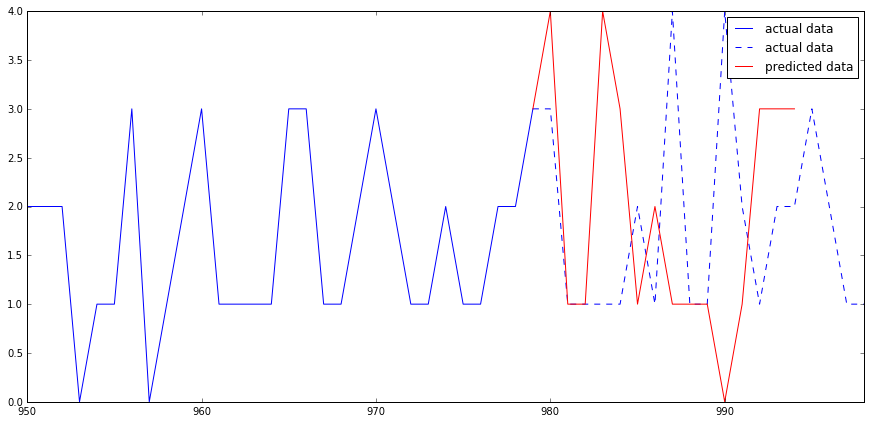

In [35]:
draw_forecast(data[:980], begin_draw_with = 950, num_forecast_days = 15, order = 5, regime = 'max')

# 2. Decision Tree

Попробуем решить задачу, используя деревья решений

In [166]:
from sklearn import datasets, tree, metrics
from functools import reduce
from matplotlib import pyplot as plt

In [167]:
def GetShiftingWindows(input_data, order):
    out_data = [list(input_data)[x:x+order] for x in range(len(list(input_data)) - order + 1)]
    return out_data

In [168]:
# data - исходные данные
# order - порядок цепи

def prepare_data(data, order):
    raw_lists = GetShiftingWindows(data.element, order+1)
    dataDT = pd.DataFrame(raw_lists)
    dataDT = dataDT.add_prefix('x')
    dataDT.rename(columns={'x'+str(order) : 'y'}, inplace=True)
    X = dataDT.drop('y', axis=1)
    y = dataDT.y.values
    return X,y

In [169]:
order = 5
X,y = prepare_data(data,order)
X.head()

,x0,x1,x2,x3,x4
0,2,4,2,2,4
1,4,2,2,4,1
2,2,2,4,1,2
3,2,4,1,2,1
4,4,1,2,1,0


Делим данные на трейн и тест

In [170]:
def split_data(X,y,test_percent):
    test_start = X.shape[0]-int(X.shape[0]*test_percent)
    X_train = X[:test_start]
    X_test = X[test_start:]
    y_train = y[:test_start]
    y_test = y[test_start:]
    return X_train, X_test, y_train, y_test

In [171]:
def rmse(predicted,real):
    squared = map(lambda x, y: (x-y)**2, predicted, real)
    rmse = reduce(lambda x,y: x+y, squared)
    rmse = (rmse/len(predicted))**0.5
    return rmse

Функция, рисующая предсказания

In [172]:
def DrawDecisionTreePredictions(data, predictions):
    
    plt.figure(figsize=(18,8))
    
    predictions_size = len(predictions)
    data_size = len(data.element)
    
    predictions = pd.DataFrame(predictions, index=range(data.index[-1]-predictions_size+1,data_size,1), columns=data.columns)
    predictions_df = pd.concat([data.element[0:data.index[-1]-predictions_size+1],predictions.element[:]])
    
    begin_draw_with = int(data_size - 1.5*predictions_size)
    
    data.element[begin_draw_with:data.index[-1]-predictions_size+2].plot(color = 'b', label = 'actual data')
    data.element[-predictions_size:].plot(linestyle='--', color = 'b', label = 'actual data')
    predictions_df[-predictions_size:].plot(color='r', label = 'predicted data')
    
    plt.legend()
    plt.show()

Поиск лучшей модели в заданном интервале порядков цепи, глубины деревьев и размера тестовой выборки

In [185]:
def FindBestDTModel(data, min_order, max_order, min_test_size, max_test_size, min_max_depth, max_max_depth):

    results = []
    i = 0

    for order in range(min_order,max_order,1):
        progressbar((order-min_order)/(max_order-min_order-1))
        X,y = prepare_data(data,order)
        for test_size in np.arange(min_test_size,max_test_size,0.01):
            for max_depth in range(min_max_depth,max_max_depth,1):
                X_train, X_test, y_train, y_test = split_data(X,y,test_size)

                DTC = tree.DecisionTreeClassifier(max_depth=max_depth, random_state=0)
                DTRes = DTC.fit(X_train, y_train)
                preds = DTC.predict(X_test)

                Accuracy = round(metrics.accuracy_score(preds,y_test),3)
                RMSE = round(rmse(preds,y_test),3)

                #print('-'*15,'(order:',num_x,', test_size:',test_size*100,'%, max_depth:',max_depth,')','-'*15)
                #print('Accuracy: ',Accuracy)
                #print('RMSE: ',RMSE)

                results.append([RMSE, Accuracy, order, test_size, max_depth, preds])
                i += 1

    results_df = pd.DataFrame(results)
    results_df.rename(columns={0:'RMSE', 1:'Accuracy', 2:'order', 3:'test_size', 4:'max_depth', 5:'predictions'}, inplace=True)
    results_df.head()

    min_rmse = results_df.loc[results_df['RMSE'].idxmin()]

    print('\nBest model: {RMSE:',min_rmse.RMSE,
                       '; Accuracy:',min_rmse.Accuracy,
                       '; order:',int(min_rmse.order),
                       '; test_size:',min_rmse.test_size,
                       '; max_depth:',int(min_rmse.max_depth),'}\n')
    
    return min_rmse.predictions

In [192]:
min_order = 44
max_order = 100

min_test_size = 0.15
max_test_size = 0.4

min_max_depth = 1
max_max_depth = 50

best_predictions = FindBestDTModel(data, min_order, max_order, min_test_size, max_test_size, min_max_depth, max_max_depth)

Percent: [####################################################################################################] 100% Done...

Best model: {RMSE: 0.899 ; Accuracy: 0.39 ; order: 91 ; test_size: 0.15 ; max_depth: 5 }



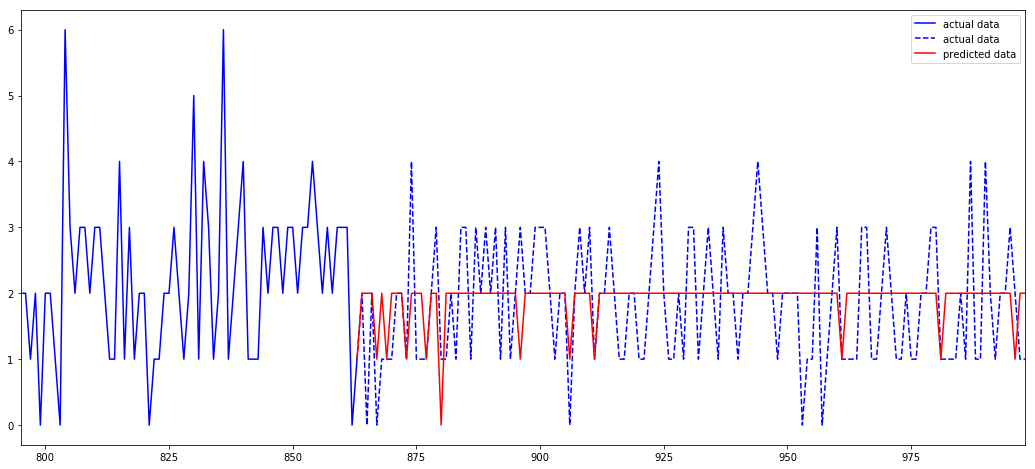

In [193]:
DrawDecisionTreePredictions(data,best_predictions)